In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import sys
import glob
sys.path.append('../../../src')

from common import common, transform, json, video
from common.functions import cos_similarity, gauss
from common.json import IA_FORMAT, START_IDX, GA_FORMAT, ATTENTION_FORMAT
from common.default import PASSING_DEFAULT
from common.object_point import OBJECT_POINTS
from individual_activity.individual_activity import IndividualActivity
from display.individual_activity import disp_individual_activity
from display.tracking import disp_tracking
from display.heatmap import Heatmap

# Attention をロード

In [2]:
data_settings = [
    {'room_num': '09', 'date': '20210304', 'option': 'attention'}
]

In [3]:
attentions = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
    
    for i, path in enumerate(tqdm(dirs)):
        path = f'{path}/json/group_activity.json'
        json_data = json.load(path)
        key = f"{room_num}_{date}_{i + 1:02d}"
        attentions[key] = json_data["attention"]

{'room_num': '09', 'date': '20210304', 'option': 'attention'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.36it/s]


# 対象物のスコアを計算
https://qiita.com/masataka46/items/cb5b05090746c7f3b826

In [4]:
def likelihood(object_point, attention_data, sigma=50):
    px = object_point[0]
    py = object_point[1]
    
    value_dict = {}
    for data in tqdm(attention_data):
        frame_num = data[ATTENTION_FORMAT[0]]
        x, y = data[ATTENTION_FORMAT[2]]
        count = data[ATTENTION_FORMAT[4]]
        gauss = np.exp(-((x - px)**2 + (y - py)**2) / (2 * sigma ** 2))
        
        if frame_num not in value_dict:
            value_dict[frame_num] = {"counts": [], "weights": []}
            
        value_dict[frame_num]["counts"].append(count)
        value_dict[frame_num]["weights"].append(gauss + 1e-10)
        
    means = {}
    for frame_num, value in value_dict.items():
        means[frame_num] = np.average(value["counts"], weights=value["weights"])
    
    return means

In [5]:
likelihood_dict = {}
for key, attention_data in attentions.items():
    room_num, date, num = key.split("_")
    num = f"{(int(num) - 1) % 3 + 1:02d}"  # for ex0304
    print(room_num, date, num)
    
    object_points = OBJECT_POINTS[room_num][date][num]
    for i, object_point in enumerate(object_points):
        value = likelihood(object_point, attention_data)
        new_key = f"{key}_{i + 1}"
        likelihood_dict[new_key] = value

09 20210304 01


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116068/116068 [00:00<00:00, 484195.78it/s]


09 20210304 02


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107147/107147 [00:00<00:00, 519351.84it/s]


09 20210304 03


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103163/103163 [00:00<00:00, 556746.15it/s]


09 20210304 01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99903/99903 [00:00<00:00, 594528.31it/s]


09 20210304 02


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98750/98750 [00:00<00:00, 514454.11it/s]


09 20210304 03


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106842/106842 [00:00<00:00, 529963.77it/s]


09 20210304 01


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109125/109125 [00:00<00:00, 536743.78it/s]


09 20210304 02


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109801/109801 [00:00<00:00, 593739.47it/s]


09 20210304 03


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112796/112796 [00:00<00:00, 643438.95it/s]


# 動画作成

In [6]:
def display_likelihood(object_point, value, heatmap_cls, field, max_radius=20, alpha=0.7):
    copy = field.copy()
    
    color = heatmap_cls.colormap(value)

    # calc radius of circle
    max_value = heatmap_cls.xmax
    radius = int(value / max_value * max_radius)
    if radius == 0:
        radius = 1
    # plot the heatmap circle
    cv2.circle(copy, object_point, radius, color, thickness=-1)

    # plot the center of object
    cv2.circle(copy, tuple(object_point), 3, (0, 0, 0), -1)
    
    point = np.array(object_point) - [50, 10]
    point = tuple(point)
    cv2.putText(copy, f"{value:.1f}", point, cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 2)
    
    field = cv2.addWeighted(copy, alpha, field, 1 - alpha, 0)
    
    # plt.imshow(field)
    # plt.show()

    return field

In [7]:
def combine_image(frame, field):
    ratio = 1 - (field.shape[0] - frame.shape[0]) / field.shape[0]
    size = [int(field.shape[1] * ratio), int(field.shape[0] * ratio)]
    if frame.shape[0] != size[1]:
        # 丸め誤差が起きる
        size[1] = frame.shape[0]
    field = cv2.resize(field, size)
    frame = np.concatenate([frame, field], axis=1)

    return frame


def display(
    video_path,
    out_path,
    individual_activity_json_path,
    likelihood_data,
    heatmap_cls,
    field,
    object_point,
):
    print(out_path)
    print("Writing video frames...")

    # load datas
    individual_activity_datas = json.load(individual_activity_json_path)

    # load video
    capture = video.Capture(video_path)

    # frames_lst = [[] for _ in range(len(out_paths))]
    cmb_img = combine_image(capture.read(), field)
    size = cmb_img.shape[1::-1]
    writer = video.Writer(out_path, capture.fps, size)

    # reset capture start position
    capture.set_pos_frame(0)

    for frame_num in tqdm(range(capture.frame_num)):
        # read frame
        frame = capture.read()

        # フレームごとにデータを取得する
        frame_individual_activity_datas = [
            data for data in individual_activity_datas if data["frame"] == frame_num
        ]

        # フレーム番号を表示
        cv2.putText(
            frame,
            "Frame:{}".format(frame_num + 1),
            (10, 50),
            cv2.FONT_HERSHEY_PLAIN,
            2,
            (0, 0, 0),
        )

        # copy raw field image
        field_tmp = field.copy()

        # draw tracking result
        frame = disp_tracking(frame_individual_activity_datas, frame)

        # draw individual activity
        field_tmp = disp_individual_activity(
            frame_individual_activity_datas, field_tmp
        )

        # draw likelihood
        field_tmp = display_likelihood(object_point, likelihood_data[frame_num], heatmap_cls, field_tmp)

        # write video
        writer.write(combine_image(frame, field_tmp))


def get_field(room_num):
    field_path = os.path.join(common.data_dir, room_num, 'field.png')
    return cv2.imread(field_path)

In [8]:
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
        
    field = get_field(room_num)
    
    for i, path in enumerate(dirs):
        ia_json_path = os.path.join(path, 'json', 'individual_activity.json')
        video_path = os.path.join(path, 'video', f'pose_{i + 1:02d}.mp4')
        out_dir = os.path.join(path, 'out')
        cap = video.Capture(video_path)
        
        num = f"{i % 3 + 1:02d}"  # for ex0304
        object_points = OBJECT_POINTS[room_num][date][num]
        for j, object_point in enumerate(object_points):
            print(object_point)
            out_path = os.path.join(out_dir, f'attention_object{j + 1}.mp4')
            key = f"{room_num}_{date}_{i + 1:02d}_{j + 1}"
            likelihood_data = likelihood_dict[key]
            max_val = np.max(list(likelihood_data.values()))
            print(max_val)
            heatmap_cls = Heatmap([0, max_val])
            display(
                video_path,
                out_path,
                ia_json_path,
                likelihood_data,
                heatmap_cls,
                field,
                object_point,
            )

{'room_num': '09', 'date': '20210304', 'option': 'attention'}
(685, 780)
0.12313545241387779
C:\Users\k2111\program\research\data/09/20210304/attention\01\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 591/591 [00:10<00:00, 56.83it/s]


(50, 780)
0.646771213205698
C:\Users\k2111\program\research\data/09/20210304/attention\02\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [00:11<00:00, 53.92it/s]


(367, 415)
1.0163500318135825
C:\Users\k2111\program\research\data/09/20210304/attention\03\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [00:10<00:00, 54.77it/s]


(685, 780)
0.09445458360044703
C:\Users\k2111\program\research\data/09/20210304/attention\04\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 562/562 [00:10<00:00, 53.87it/s]


(50, 780)
0.6901479552579766
C:\Users\k2111\program\research\data/09/20210304/attention\05\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 581/581 [00:10<00:00, 56.37it/s]


(367, 415)
1.294287118357086
C:\Users\k2111\program\research\data/09/20210304/attention\06\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 572/572 [00:10<00:00, 54.91it/s]


(685, 780)
0.14649450606802994
C:\Users\k2111\program\research\data/09/20210304/attention\07\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 603/603 [00:11<00:00, 53.53it/s]


(50, 780)
0.6311530139116974
C:\Users\k2111\program\research\data/09/20210304/attention\08\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:11<00:00, 52.06it/s]


(367, 415)
1.3938976671989707
C:\Users\k2111\program\research\data/09/20210304/attention\09\out\attention_object1.mp4
Writing video frames...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 595/595 [00:11<00:00, 51.58it/s]


# 修論用解析
## ヒストグラム、箱ひげ図

In [6]:
def get_start_attention_frame(csv_path):
    csv_data = np.loadtxt(csv_path, delimiter=',', skiprows=1, dtype=int)
    for row in csv_data:
        if row[4] != 0:
            return row[0]

In [7]:
def boxplot(pos_data_lst, nega_data_lst):
    fig = plt.figure(figsize=(5, 2))
    axs = [
        fig.add_axes((0.1, 0.1, 0.29, 0.85)),
        fig.add_axes((0.4, 0.1, 0.29, 0.85)),
        fig.add_axes((0.7, 0.1, 0.29, 0.85))
    ]

    for j in range(3):
        data_dict = {}
        label1 = f'O{j % 3 + 1}-A'
        label2 = f'O{j % 3 + 1}-N/A'

        data_dict[label1] = pos_data_lst[j]
        data_dict[label2] = nega_data_lst[j]

        # adjust length of data
        max_len = max([len(vals) for vals in data_dict.values()])
        for key, vals in data_dict.items():
            if len(vals) < max_len:
                data_dict[key] = list(vals) + [np.nan for _ in range(max_len - len(vals))]
        df = pd.DataFrame.from_dict(data_dict)
        df = pd.melt(df)

        sns.boxplot(x='variable', y='value', data=df, showfliers=False, ax=axs[j])
        axs[j].set_ylabel('')
        axs[j].set_xlabel('')
        axs[j].set_ylim((0, 1.5))

    axs[0].set_ylabel('Attention Score')
    axs[1].set_yticklabels([])
    axs[2].set_yticklabels([])

    box_path = os.path.join(common.data_dir, 'image', opt, f'box_{room_num}_{date}_{i // 3 + 1}.pdf')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.savefig(box_path)

In [8]:
def hist(pos_data_lst, nega_data_lst):
    fig = plt.figure(figsize=(5, 2))
    axs = [
        fig.add_axes((0.06, 0.2, 0.26, 0.75)),
        fig.add_axes((0.39, 0.2, 0.26, 0.75)),
        fig.add_axes((0.72, 0.2, 0.26, 0.75))
    ]

    for j in range(3):
        data_dict = {}
        label1 = f'O{j % 3 + 1}-A'
        label2 = f'O{j % 3 + 1}-N/A'
        labels = [label1, label2]

        data_dict[label1] = pos_data_lst[j]
        data_dict[label2] = nega_data_lst[j]

        # adjust length of data
        max_len = max([len(vals) for vals in data_dict.values()])
        for key, vals in data_dict.items():
            if len(vals) < max_len:
                data_dict[key] = list(vals) + [np.nan for _ in range(max_len - len(vals))]
        df = pd.DataFrame.from_dict(data_dict)
        df = pd.melt(df)
        
        sns.histplot(
            data=df, x='value', hue='variable', bins=20, kde=True, ax=axs[j]
        )
        
        axs[j].set_ylabel('')
        axs[j].set_xlabel('')
        axs[j].legend(labels=labels[::-1], fontsize=7, handlelength=0.5, handletextpad=0.2)

        axs[j].set_xlabel('Attention Score')

    box_path = os.path.join(common.data_dir, 'image', opt, f'hist_{room_num}_{date}_{i // 3 + 1}.pdf')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.savefig(box_path)

{'room_num': '09', 'date': '20210304', 'option': 'attention'}


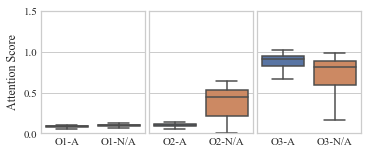

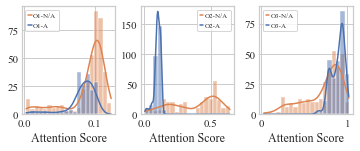

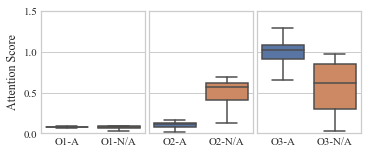

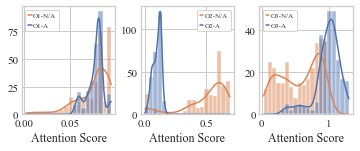

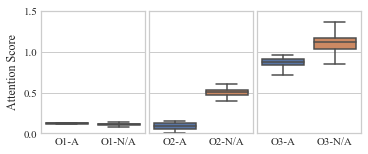

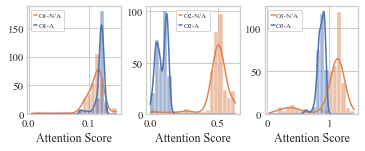

In [9]:
sns.set()
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
    if dirs[-1].endswith('image'):
        dirs = dirs[:-1]
    
    pos_data_lst = []
    nega_data_lst = []
    for i, path in enumerate(dirs):
        # get start attention frame
        csv_path = os.path.join(path, 'csv', 'data.csv')
        start_frame = get_start_attention_frame(csv_path)
        
        # get data and split positeve and negative
        key = f"{room_num}_{date}_{i + 1:02d}_{1}"
        data = list(likelihood_dict[key].values())
        pos_data = data[start_frame:]
        nega_data = data[:start_frame]
        
        pos_data_lst.append(pos_data)
        nega_data_lst.append(nega_data)
        
        # plot
        if i % 3 == 2:
            # plot per 3 times
            boxplot(pos_data_lst, nega_data_lst)
            hist(pos_data_lst, nega_data_lst)
            pos_data_lst = []
            nega_data_lst = []

## 検定

In [10]:
from scipy import stats

In [20]:
import pandas as pd

def mwu(data1, data2):
    n1, n2 = len(data1), len(data2)
    mu = n1 * n2 / 2
    sigma = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    
    label1 = [1 for _ in range(n1)]
    data1_df = pd.DataFrame({
        'label': label1,
        'value': data1
    })
    label2 = [2 for _ in range(n2)]
    data2_df = pd.DataFrame({
        'label': label2,
        'value': data2
    })
    
    df = pd.concat([data1_df, data2_df], axis=0)
    df = pd.concat([df, df.rank()["value"]], axis=1)
    df.columns = ["label", "value", "rank"]
    print(df.head())
    print(df.tail())
    
    df[df["label"] == 1]["rank"].hist()
    plt.show()
    df[df["label"] == 2]["rank"].hist()
    plt.show()
    
    rank_sum1 = df[df["label"] == 1].sum()["rank"]
    rank_sum2 = df[df["label"] == 2].sum()["rank"]
    print('rank sum:', rank_sum1, rank_sum2)
    
    u1 = n1 * n2 + n1 * (n1 + 1) / 2 - rank_sum1
    u2 = n1 * n2 - u1
    print('u1, u2 ', u1, u2)
    
    u = u1 if u1 > mu else u2
    print('u=', u)
        
    z = (u1 - mu) / sigma
    print('z=', z)
    
    p = stats.norm.pdf(z)
    print("p=", p)

{'room_num': '09', 'date': '20210304', 'option': 'attention'}
O_1
   label     value  rank
0      1  0.344821   2.0
1      1  0.554161  11.0
2      1  0.931411  17.0
3      1  0.987323  18.0
4      1  1.306170  22.0
     label     value  rank
408      2  5.569941  82.0
409      2  6.258255  90.0
410      2  6.465273  94.0
411      2  3.546851  53.0
412      2  0.495759   8.0


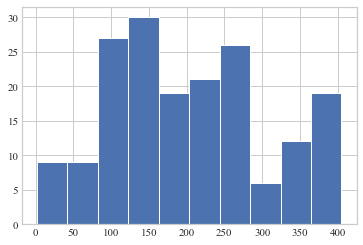

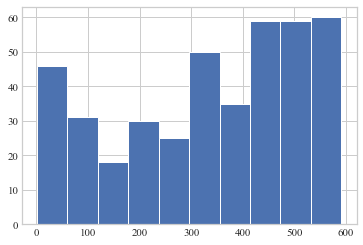

rank sum: 36178.0 138758.0
u1, u2  53267.0 20247.0
u= 53267.0
z= 8.66945538458791
p= 1.9065202370300475e-17
O_2
   label     value  rank
0      1  0.396677   1.0
1      1  0.793341   4.0
2      1  1.194180   5.0
3      1  1.503953   7.0
4      1  1.899721  10.0
     label     value  rank
325      2  7.381849  52.0
326      2  2.754208  14.0
327      2  5.259398  30.0
328      2  1.733607   8.0
329      2  0.506827   3.0


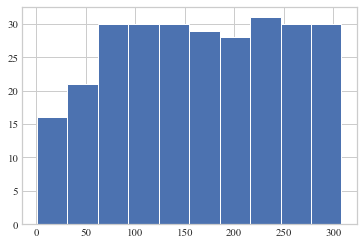

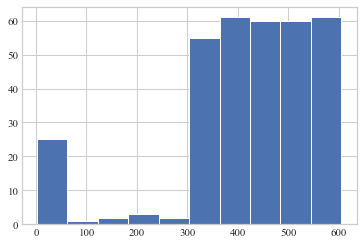

rank sum: 45353.0 137962.0
u1, u2  83347.0 7403.0
u= 83347.0
z= 17.7375840459962
p= 1.912648611377346e-69
O_3
   label      value   rank
0      1  64.544017   92.0
1      1  66.697489   99.0
2      1  67.280185  100.0
3      1  67.640520  101.0
4      1  73.657053  124.0
     label      value   rank
319      2  63.137698   88.0
320      2  64.271063   91.0
321      2  67.803126  102.0
322      2  69.275616  106.0
323      2  65.602218   94.0


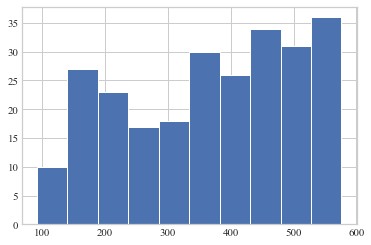

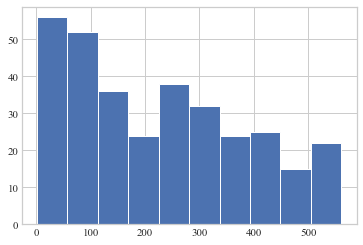

rank sum: 92788.0 73388.0
u1, u2  20738.0 60910.0
u= 60910.0
z= -10.137325682115742
p= 1.930603431807306e-23
O_1
   label     value  rank
0      1  5.957195  73.0
1      1  5.951374  70.0
2      1  5.945589  68.0
3      1  5.939830  67.0
4      1  5.958285  74.0
     label     value   rank
297      2  9.077483  478.0
298      2  9.072338  476.0
299      2  6.004025   79.0
300      2  5.971588   77.0
301      2  5.961050   75.0


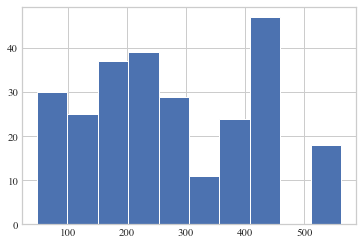

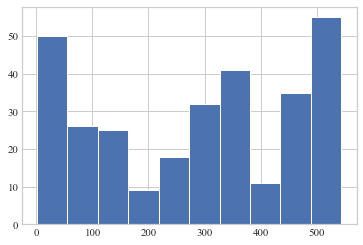

rank sum: 71778.0 86425.0
u1, u2  40672.0 37848.0
u= 40672.0
z= 0.7356664945763429
p= 0.3043608944690978
O_2
   label     value  rank
0      1  1.958910  24.0
1      1  1.971373  25.0
2      1  2.186985  27.0
3      1  1.829802  22.0
4      1  3.041802  29.0
     label     value  rank
313      2  0.742098  11.0
314      2  0.870231  13.0
315      2  1.465966  20.0
316      2  0.490398   5.0
317      2  1.328795  19.0


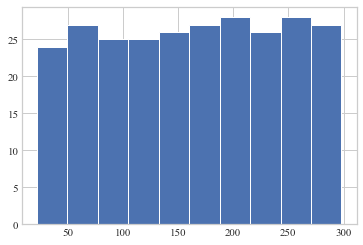

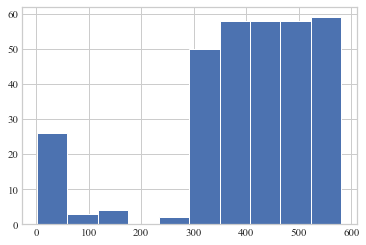

rank sum: 42778.0 126293.0
u1, u2  75572.0 8062.0
u= 75572.0
z= 16.760069251982806
p= 4.020380567958093e-62
O_3
   label      value   rank
0      1  51.240681  143.0
1      1  35.160401   95.0
2      1  34.523222   91.0
3      1  33.250278   88.0
4      1  36.908551  101.0
     label      value   rank
304      2  75.081015  215.0
305      2  74.441037  213.0
306      2  72.427437  204.0
307      2  70.092401  196.0
308      2  65.938234  185.0


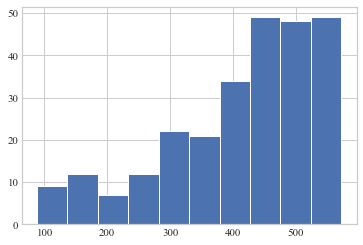

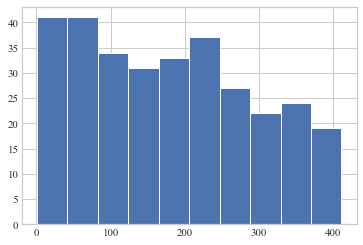

rank sum: 108353.0 55525.0
u1, u2  7630.0 73637.0
u= 73637.0
z= -16.753910729864565
p= 4.4574411147435075e-62
O_1
   label      value   rank
0      1  10.982163  164.0
1      1  11.159324  182.0
2      1  11.173582  184.0
3      1  11.216317  189.0
4      1  11.233183  192.0
     label      value   rank
342      2  11.839406  315.0
343      2  10.824121  143.0
344      2  10.851318  146.0
345      2  10.889637  153.0
346      2  10.918165  158.0


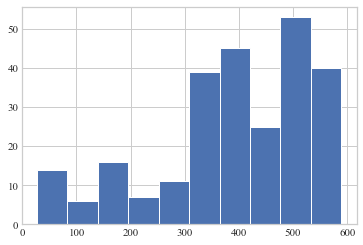

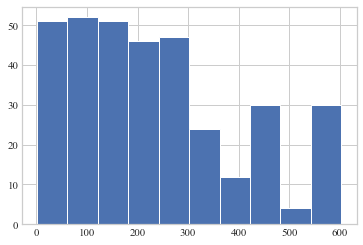

rank sum: 100085.0 82021.0
u1, u2  21643.0 67189.0
u= 67189.0
z= -10.769801028564677
p= 2.595986989821083e-26
O_2
   label     value  rank
0      1  0.393921   4.0
1      1  0.593276   5.0
2      1  0.770532   6.0
3      1  0.932409   7.0
4      1  1.089994   8.0
     label      value   rank
313      2  18.079129  290.0
314      2   5.584314   86.0
315      2   0.319359    2.0
316      2   0.224338    1.0
317      2   0.322384    3.0


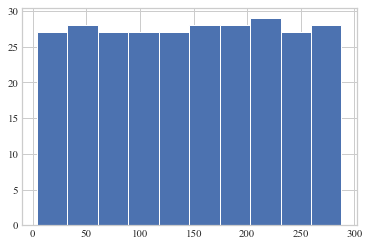

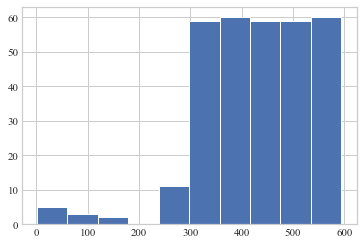

rank sum: 40436.0 136279.0
u1, u2  85558.0 2210.0
u= 85558.0
z= 19.976952019420327
p= 8.751662279795754e-88
O_3
   label      value  rank
0      1  58.742705  49.0
1      1  61.539243  51.0
2      1  62.224784  53.0
3      1  61.806229  52.0
4      1  64.959962  55.0
     label      value  rank
333      2  46.904487  40.0
334      2  49.700822  42.0
335      2  52.083785  44.0
336      2  53.761468  45.0
337      2  55.968472  47.0


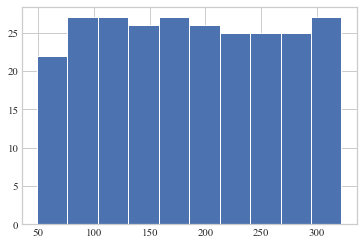

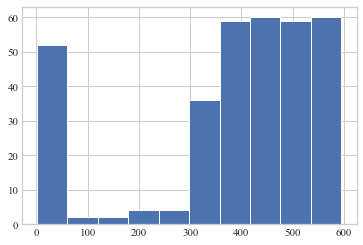

rank sum: 47932.0 129378.0
u1, u2  72087.0 14779.0
u= 72087.0
z= 13.795194813762373
p= 1.8887880834622783e-42


In [21]:
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
    
    for i, path in enumerate(dirs):
        # get start attention frame
        csv_path = os.path.join(path, 'csv', 'data.csv')
        start_frame = get_start_attention_frame(csv_path)
        
        # get data and split positeve and negative
        key = f"{room_num}_{date}_{i + 1:02d}_{1}"
        data = np.array(list(likelihood_dict[key].values())) * 100
        pos_data = data[start_frame:]
        nega_data = data[:start_frame]
        
        print(f"O_{i % 3 + 1}")
        mwu(pos_data, nega_data)

In [19]:
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
    
    for i, path in enumerate(dirs):
        # get start attention frame
        csv_path = os.path.join(path, 'csv', 'data.csv')
        start_frame = get_start_attention_frame(csv_path)
        
        # get data and split positeve and negative
        key = f"{room_num}_{date}_{i + 1:02d}_{1}"
        data = np.array(list(likelihood_dict[key].values())) * 100
        pos_data = data[start_frame:]
        nega_data = data[:start_frame]
        
        w = stats.mannwhitneyu(pos_data, nega_data, alternative='greater')
        print(f"O_{i % 3 + 1}")
        print('Mann-Whitney U', f"statistic: {w.statistic:.3f}", f"p: {w.pvalue:.3f}")

{'room_num': '09', 'date': '20210304', 'option': 'attention'}
O_1
Mann-Whitney U statistic: 20247.000 p: 1.000
O_2
Mann-Whitney U statistic: 7403.000 p: 1.000
O_3
Mann-Whitney U statistic: 60910.000 p: 0.000
O_1
Mann-Whitney U statistic: 37848.000 p: 0.769
O_2
Mann-Whitney U statistic: 8062.000 p: 1.000
O_3
Mann-Whitney U statistic: 73637.000 p: 0.000
O_1
Mann-Whitney U statistic: 67189.000 p: 0.000
O_2
Mann-Whitney U statistic: 2210.000 p: 1.000
O_3
Mann-Whitney U statistic: 14779.000 p: 1.000
